# 「駐車場」特徴量について抽出する！

In [94]:
import pandas as pd
import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer
import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [95]:
train_df = pd.read_csv("../data/outer_data/train.csv")
test_df = pd.read_csv('../data/outer_data/test.csv')

In [96]:
train_df.head(2)

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間


### テキスト整形用関数

In [97]:
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[『』]', ' ', replaced_text)   # 『』の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = re.sub(r' ', '', replaced_text)  # 空白の除去
    return replaced_text


def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_html_and_js_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    [x.extract() for x in soup.findAll(['script', 'style'])]
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def text_cleaning(text):
    text = clean_text(text)
    text = clean_html_tags(text)
    text = clean_html_and_js_tags(text)
    text = clean_url(text)
    text = normalize(text)
    text = lower_text(text)
    text = normalize_unicode(text)

    return text

「駐車場」特徴量について抽出

In [98]:
parking = train_df['駐車場'].copy()

In [99]:
for i in range(len(parking)):
    try:
        parking.loc[i] = clean_text(parking.loc[i])
        parking.loc[i] = parking.loc[i].replace('／', '')
        parking.loc[i] = parking.loc[i].replace('\t', ' ')
        parking.loc[i] = parking.loc[i].replace(' 無', '無 ')
        parking.loc[i] = parking.loc[i].replace(' 空有', '空有 ')
        parking.loc[i] = parking.loc[i].replace(' 空無', '空無 ')
        parking.loc[i] = parking.loc[i].replace(' 近隣', '近隣 ')
    except:
        pass

In [100]:
parking[30:50]

30                              駐車場空無  28,000円税込
31                                駐車場空有  15,000円
32               駐車場空有  15,000円 駐輪場空有  バイク置き場空有 
33       駐輪場空有  駐車場近隣  30,000円税込 距離200m バイク置き場無 
34             駐車場空有  32,400円税込 駐輪場空有  バイク置き場空有 
35        駐車場近隣  21,600円税込 距離300m 駐輪場無  バイク置き場無 
36          駐車場空有  17,280円税込 屋根無 駐輪場空有  バイク置き場無 
37       駐輪場空有  駐車場近隣  27,000円税込 距離100m バイク置き場無 
38                              駐車場空有  27,000円税込
39    駐輪場空有  バイク置き場空有  駐車場近隣  12,960円 距離200m 平置駐
40                                         駐車場無 
41      駐輪場空有  バイク置き場空有  駐車場近隣  32,000円税込 距離500m
42                        駐輪場空有  0円税無 登録制・1台まで無料
43                                           NaN
44             駐車場空有  12,000円税込 駐輪場空有  バイク置き場空有 
45        駐車場近隣  21,600円税込 距離200m 駐輪場無  バイク置き場無 
46                                     バイク置き場空有 
47                                         駐車場無 
48                                         駐車場無 
49                                駐輪場無  バイク置き場無 
Name: 駐車場, dtype: ob

In [101]:
from cmath import nan


parkings = []
for i in range(len(parking)):
    text = parking.loc[i]
    parking_list = []
    try:
        if '駐車場空有' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if '駐車場空無' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if '駐車場無' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if '駐車場近隣' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if '駐輪場空有' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if '駐輪場無' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if 'バイク置き場無' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if 'バイク置き場空有' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)        

        

    except:#「キッチン」特徴量に何も記載がない場合
        parking_list = [0 for k in range(8)] #ホントに0埋めで良いの？

    parkings.append( parking_list )

parkings = pd.DataFrame( parkings )

In [102]:
parkings.columns = ['駐車場空有','駐車場空無','駐車場無','駐車場近隣',
'駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有']

In [103]:
parkings.to_csv('../data/handmade_data/parkings.csv',index=False)

テストデータにも同様の処理を行う

In [104]:
parking = test_df['駐車場'].copy()

In [105]:
for i in range(len(parking)):
    try:
        parking.loc[i] = clean_text(parking.loc[i])
        parking.loc[i] = parking.loc[i].replace('／', '')
        parking.loc[i] = parking.loc[i].replace('\t', ' ')
        parking.loc[i] = parking.loc[i].replace(' 無', '無 ')
        parking.loc[i] = parking.loc[i].replace(' 空有', '空有 ')
        parking.loc[i] = parking.loc[i].replace(' 空無', '空無 ')
        parking.loc[i] = parking.loc[i].replace(' 近隣', '近隣 ')
    except:
        pass

In [106]:
from cmath import nan


parkings = []
for i in range(len(parking)):
    text = parking.loc[i]
    parking_list = []
    try:
        if '駐車場空有' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if '駐車場空無' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if '駐車場無' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if '駐車場近隣' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if '駐輪場空有' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if 'バイク置き場無' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)

        if 'バイク置き場空有' in text:
            parking_list.append(1)
        else:
            parking_list.append(0)        

        

    except:#「キッチン」特徴量に何も記載がない場合
        parking_list = [0 for k in range(7)] #ホントに0埋めで良いの？

    parkings.append( parking_list )

parkings = pd.DataFrame( parkings )

In [107]:
parkings.columns = ['駐車場空有','駐車場空無','駐車場近隣',
'駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有']

In [108]:
parkings.to_csv('../data/test_data/test_parkings.csv',index=False)

作成したこの特徴量をLightGBMに突っ込む！

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
bath_toilet_points = pd.read_csv('../data/handmade_data/bath_toilet_points.csv')
broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
parkings = pd.read_csv('../data/handmade_data/parkings.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_bath_toilet_points = pd.read_csv('../data/test_data/test_bath_toilet_points.csv')
test_broadcasts = pd.read_csv('../data/handmade_data/broadcasts.csv')
test_parkings = pd.read_csv('../data/test_data/test_parkings.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent,sepa_bath_toilets, floor_scores2, Floor_scores2, 
                    stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], 
                    buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms, 
                    parkings], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent,test_sepa_bath_toilets, test_floor_scores2, test_Floor_scores2, 
                    test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],
                    test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms,
                    test_parkings], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
                    '駐車場空有','駐車場空無','駐車場無','駐車場近隣',
                    '駐輪場空有','駐輪場無','バイク置き場無','バイク置き場空有'
                    ]

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 28
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48832.3	valid_1's rmse: 50177.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '駐車場無', '駐車場空有', '駐車場空無', '駐車場近隣', '駐輪場無', '駐輪場空有']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be rem

[20]	training's rmse: 34621.4	valid_1's rmse: 37951.3
[30]	training's rmse: 26154.4	valid_1's rmse: 31023.1
[40]	training's rmse: 21194.7	valid_1's rmse: 27182.7
[50]	training's rmse: 17955.4	valid_1's rmse: 24794.6
[60]	training's rmse: 15978.4	valid_1's rmse: 23359.3
[70]	training's rmse: 14599.2	valid_1's rmse: 22353.2
[80]	training's rmse: 13648.4	valid_1's rmse: 21689.7
[90]	training's rmse: 12889.3	valid_1's rmse: 21190.6
[100]	training's rmse: 12215.6	valid_1's rmse: 20715.5
[110]	training's rmse: 11658.1	valid_1's rmse: 20308.7
[120]	training's rmse: 11201.8	valid_1's rmse: 19991.9
[130]	training's rmse: 10818.9	valid_1's rmse: 19744.6
[140]	training's rmse: 10463.5	valid_1's rmse: 19510
[150]	training's rmse: 10119.6	valid_1's rmse: 19293.5
[160]	training's rmse: 9833.5	valid_1's rmse: 19101
[170]	training's rmse: 9558.23	valid_1's rmse: 18918.1
[180]	training's rmse: 9302.41	valid_1's rmse: 18742.6
[190]	training's rmse: 9085.81	valid_1's rmse: 18591.7
[200]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '駐車場無', '駐車場空有', '駐車場空無', '駐車場近隣', '駐輪場無', '駐輪場空有']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be rem

[30]	training's rmse: 26835.5	valid_1's rmse: 28241.3
[40]	training's rmse: 22132.8	valid_1's rmse: 24072.8
[50]	training's rmse: 19213.1	valid_1's rmse: 21452.9
[60]	training's rmse: 17416.4	valid_1's rmse: 19963.6
[70]	training's rmse: 16109.2	valid_1's rmse: 19100.1
[80]	training's rmse: 15055.7	valid_1's rmse: 18442.2
[90]	training's rmse: 14203.6	valid_1's rmse: 18106.2
[100]	training's rmse: 13562.1	valid_1's rmse: 17908.5
[110]	training's rmse: 13024.8	valid_1's rmse: 17764.6
[120]	training's rmse: 12580.8	valid_1's rmse: 17652.8
[130]	training's rmse: 12139.4	valid_1's rmse: 17640.4
[140]	training's rmse: 11717.8	valid_1's rmse: 17638.8
Early stopping, best iteration is:
[133]	training's rmse: 12001.3	valid_1's rmse: 17617.1
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '駐車場無', '駐車場空有', '駐車場空無', '駐車場近隣', '駐輪場無', '駐輪場空有']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be rem

[30]	training's rmse: 26869.4	valid_1's rmse: 27109.3
[40]	training's rmse: 22107.2	valid_1's rmse: 22901.7
[50]	training's rmse: 19147.7	valid_1's rmse: 20447
[60]	training's rmse: 17286.8	valid_1's rmse: 19232.3
[70]	training's rmse: 15991.4	valid_1's rmse: 18566
[80]	training's rmse: 14987.7	valid_1's rmse: 18206.9
[90]	training's rmse: 14190	valid_1's rmse: 17970.1
[100]	training's rmse: 13563.6	valid_1's rmse: 17705.9
[110]	training's rmse: 13032.7	valid_1's rmse: 17573.2
[120]	training's rmse: 12555.3	valid_1's rmse: 17450.8
[130]	training's rmse: 12097.5	valid_1's rmse: 17341.2
[140]	training's rmse: 11708.3	valid_1's rmse: 17309.8
[150]	training's rmse: 11338.2	valid_1's rmse: 17233.2
[160]	training's rmse: 11003.8	valid_1's rmse: 17198.1
[170]	training's rmse: 10690.3	valid_1's rmse: 17169
[180]	training's rmse: 10415	valid_1's rmse: 17140.3
[190]	training's rmse: 10148.4	valid_1's rmse: 17157.5
Early stopping, best iteration is:
[185]	training's rmse: 10272.9	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '駐車場無', '駐車場空有', '駐車場空無', '駐車場近隣', '駐輪場無', '駐輪場空有']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be rem

[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49015.1	valid_1's rmse: 47990
[20]	training's rmse: 34793.9	valid_1's rmse: 35790.7
[30]	training's rmse: 26297.1	valid_1's rmse: 28872.5
[40]	training's rmse: 21380.9	valid_1's rmse: 25269.4
[50]	training's rmse: 18374.6	valid_1's rmse: 23460.6
[60]	training's rmse: 16594.2	valid_1's rmse: 22564.5
[70]	training's rmse: 15283.1	valid_1's rmse: 21948.8
[80]	training's rmse: 14409.4	valid_1's rmse: 21572.4
[90]	training's rmse: 13689	valid_1's rmse: 21339.5
[100]	training's rmse: 13089.6	valid_1's rmse: 21058.5
[110]	training's rmse: 12612.4	valid_1's rmse: 20957.8
[120]	training's rmse: 12162.9	valid_1's rmse: 20725.5
[130]	training's rmse: 11781.6	valid_1's rmse: 20648.7
[140]	training's rmse: 11419	valid_1's rmse: 20591.4
[150]	training's rmse: 11082.1	valid_1's rmse: 20455.9
[160]	training's rmse: 10772.3	valid_1's rmse: 20412.8
[170]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'バイク置き場無', 'バイク置き場空有', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅', '駐車場無', '駐車場空有', '駐車場空無', '駐車場近隣', '駐輪場無', '駐輪場空有']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be rem

[10]	training's rmse: 48780.8	valid_1's rmse: 51296.8
[20]	training's rmse: 35076.9	valid_1's rmse: 37146.4
[30]	training's rmse: 27028.7	valid_1's rmse: 28815.6
[40]	training's rmse: 22366.4	valid_1's rmse: 23789.4
[50]	training's rmse: 19214.8	valid_1's rmse: 20930.4
[60]	training's rmse: 17242.1	valid_1's rmse: 19468.9
[70]	training's rmse: 15903.8	valid_1's rmse: 18478.4
[80]	training's rmse: 14911.2	valid_1's rmse: 17960.4
[90]	training's rmse: 14145.7	valid_1's rmse: 17625.4
[100]	training's rmse: 13539.1	valid_1's rmse: 17309.6
[110]	training's rmse: 13023.8	valid_1's rmse: 17143.4
[120]	training's rmse: 12603	valid_1's rmse: 16988.4
[130]	training's rmse: 12191	valid_1's rmse: 16801.5
[140]	training's rmse: 11796.1	valid_1's rmse: 16688.9
[150]	training's rmse: 11454.7	valid_1's rmse: 16578.4
[160]	training's rmse: 11134.6	valid_1's rmse: 16480.9
[170]	training's rmse: 10860.7	valid_1's rmse: 16356.1
[180]	training's rmse: 10580.2	valid_1's rmse: 16258.4
[190]	training's rmse: 

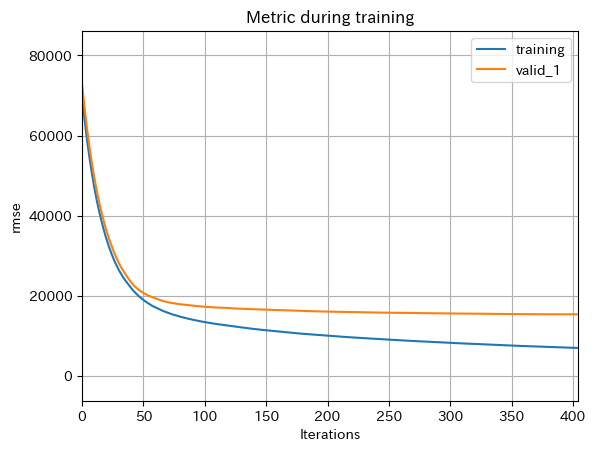

,importance
面積,4.499499e+14
L,3.991439e+14
平均地価,2.006158e+14
最寄り駅,9.406186e+13
築年数,6.903368e+13
所在地,3.893390e+13
全体の階数,3.209781e+13
一部屋あたりの面積,2.747839e+13
契約期間,1.339586e+13
所在階,1.185179e+13


In [4]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [114]:
df_importance.head(30)

,importance
面積,4.418457e+14
L,3.945508e+14
平均地価,1.998917e+14
最寄り駅,9.416939e+13
築年数,5.886148e+13
所在地,3.657222e+13
一部屋あたりの面積,2.448886e+13
全体の階数,2.234918e+13
洗面台独立,1.423421e+13
契約期間,1.353990e+13


### 駐車場関係はない方が良い？